## 画像データセット

Dogs vs. Cats より  
https://www.kaggle.com/c/dogs-vs-cats/data

In [12]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import gc

import torch

import warnings
warnings.simplefilter('ignore')

In [5]:
print(torch.__version__)

1.10.0+cu111


In [6]:
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Dataset の作成 テーブルデータ

In [7]:
import category_encoders as ce

In [8]:
titanic_df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

oe =  ce.OrdinalEncoder(cols=titanic_df.select_dtypes(include="object") ,handle_unknown='impute')

titanic_df = oe.fit_transform(titanic_df)

display(titanic_df.head(3))

y = torch.Tensor(titanic_df['Survived'].values)
X = torch.Tensor(titanic_df.drop('Survived', axis=1).values)
 
# Datasetを作成
table_dataset = torch.utils.data.TensorDataset(X, y)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,1,1,22.0,1,0,1,7.2500,1,1
1,2,1,1,2,2,38.0,1,0,2,71.2833,2,2
2,3,1,3,3,2,26.0,0,0,3,7.9250,1,1


In [18]:
del titanic_df, table_dataset, X, y
gc.collect()

0

## Dataset の内容の出力 テーブルデータ

In [9]:
train_line, target_line = table_dataset[0][0], table_dataset[0][1]
print("説明変数 ", train_line)
print("目的変数 ", target_line)

説明変数  tensor([ 1.0000,  3.0000,  1.0000,  1.0000, 22.0000,  1.0000,  0.0000,  1.0000,
         7.2500,  1.0000,  1.0000])
目的変数  tensor(0.)


## 画像データセット用のデータの作成

In [10]:
import glob

In [44]:
path_names = glob.glob("/content/drive/MyDrive/kaggle/dog_cat/train/*.jpg")
file_names = [path_name.split("/")[7] for path_name in path_names]
labels = [labels.split(".")[0] for labels in file_names]

In [45]:
train = pd.DataFrame(
    [
        path_names,
        file_names,
        labels,
    ]

).T

train.columns = ["path", "filename", "category"]

train["label"] = -1 # カラム作成のための処理
train["label"] =  train["label"].mask(train["category"]=="cat", 0)
train["label"] = train["label"].mask(train["category"]=="dog", 1)

print(train["category"].value_counts())
print(train["label"].value_counts())

display(train.head())

cat    12500
dog    11639
Name: category, dtype: int64
0    12500
1    11639
Name: label, dtype: int64


,path,filename,category,label
0,/content/drive/MyDrive/kaggle/dog_cat/train/ca...,cat.9092.jpg,cat,0
1,/content/drive/MyDrive/kaggle/dog_cat/train/ca...,cat.91.jpg,cat,0
2,/content/drive/MyDrive/kaggle/dog_cat/train/ca...,cat.9067.jpg,cat,0
3,/content/drive/MyDrive/kaggle/dog_cat/train/ca...,cat.9118.jpg,cat,0
4,/content/drive/MyDrive/kaggle/dog_cat/train/ca...,cat.9114.jpg,cat,0


In [46]:
del path_names, file_names, labels
gc.collect()

100

## パラメーター

In [47]:
BATCH_SIZE = 64
SIZE = 128
RESIZE = 64
EPOCHS = 1

## Dataset Class の定義 Transform なし

In [19]:
from torch.utils.data import Dataset
from PIL import Image

In [20]:
class MyDataset(Dataset):
    def __init__(self, train_df, input_size):
        super().__init__()
        
        self.train_df = train_df
        image_paths = train_df["path"].to_list()
        self.input_size = input_size
        self.len = len(image_paths)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        image_path = self.train_df["path"].to_list()[index]
        
        # 画像の読込
        image = Image.open(image_path)
        image = image.resize(self.input_size)
        image = np.array(image).astype(np.float32).transpose(2, 1, 0)
        
        # ラベル (0: cat, 1: dog)
        label = self.train_df["label"].to_list()[index]

        # カテゴリ (cat, dog)
        category = self.train_df["category"].to_list()[index]
        
        return image, label, category

## Datasetの作成 画像 Transform なし

In [48]:
image_dataset = MyDataset(
                        train, 
                        (SIZE, SIZE), 
                    )

## Dataset の中身を出力 画像 Transform なし

(3, 128, 128) <class 'numpy.ndarray'> 0 cat 24139


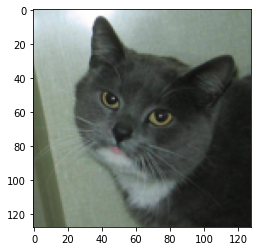

In [22]:
image, label, category = image_dataset[0]
print(image.shape, type(image), label, category, len(image_dataset))
plt.imshow(image.transpose(2, 1, 0).astype(np.uint8))

## Dataset Class の定義 Transform あり

In [49]:
class MyDataset(Dataset):
    def __init__(self, train_df, input_size, transform=None):
        super().__init__()
        
        self.train_df = train_df
        image_paths = train_df["path"].to_list()
        self.input_size = input_size
        self.len = len(image_paths)
        self.transform = transform
               
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        image_path = self.train_df["path"].to_list()[index]
        
        # 画像の読込
        image = Image.open(image_path)
        image = image.resize(self.input_size)
        image = np.array(image)

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']

        else:
            image = np.array(image).astype(np.float32).transpose(2, 1, 0)

        # ラベル (0: cat, 1: dog)
        label = self.train_df["label"].to_list()[index]

        # カテゴリ (cat, dog)
        category = self.train_df["category"].to_list()[index]
        
        return image, label, category

### 画像変換・拡張の定義

In [50]:
import torchvision.transforms as transforms
import albumentations
from albumentations.pytorch import ToTensorV2

In [51]:
transformer =  albumentations.Compose(
        [
            albumentations.RandomCrop(width=RESIZE, height=RESIZE),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.RandomBrightnessContrast(p=0.2),
            ToTensorV2(),
        ]
    )

## Datasetの作成 画像 Transform あり

In [52]:
image_dataset = MyDataset(
                        train, 
                        (SIZE, SIZE), 
                        transform=transformer
                     )

## Dataset の出力 Transform あり

torch.Size([3, 64, 64]) <class 'torch.Tensor'> 0 cat 24139


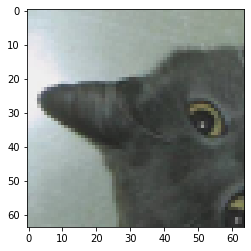

In [53]:
image, label, category = image_dataset[0]
print(image.shape, type(image), label, category, len(image_dataset))
plt.imshow(image.numpy().transpose(2, 1, 0))

## 作成したDataset を学習データと評価データに分割

In [54]:
train_dataset, valid_dataset = torch.utils.data.random_split(
    image_dataset, 
    [int(len(image_dataset)*0.7)+1, int(len(image_dataset)*0.3)]
)

print(len(train_dataset), len(valid_dataset))

16898 7241


## DataLoader -> バッチデータの作成

In [55]:
from torch.utils.data import DataLoader

In [56]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=2, 
    drop_last=True,
    pin_memory=True
)

In [57]:
valid_dataloader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=2, 
    drop_last=True,
    pin_memory=True
)

## Dataloader の中身を出力

torch.Size([8, 3, 64, 64]) tensor([0, 1, 0, 0, 0, 0, 1, 0]) ['cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat']
torch.Size([8, 3, 64, 64]) tensor([1, 0, 0, 1, 0, 0, 1, 1]) ['dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog']


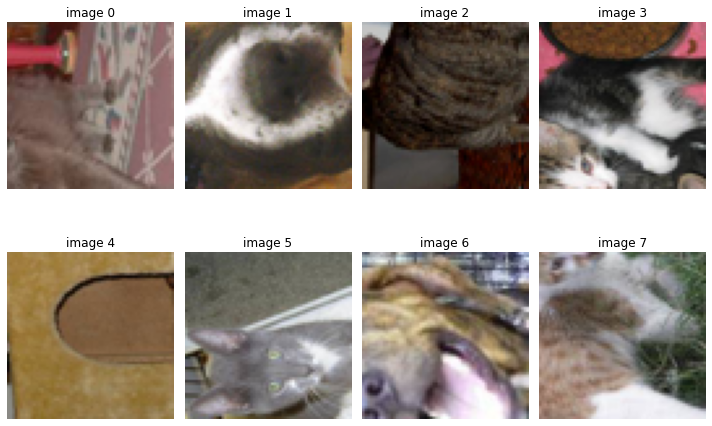

In [33]:
tmp = train_dataloader.__iter__()
batch1, label1, category1 = tmp.next() 
batch2, label2, category2  = tmp.next()

print(batch1.shape, label1, category1)
print(batch2.shape, label2, category2)

# 画像を出力
plt.figure(figsize = (10, 10))

for i in range(batch1.shape[0]):
    plt.subplot(batch1.shape[0]//4+1, 4, i+1)
    plt.title(f"image {i}")
    plt.axis("off")
    plt.imshow(batch1[i, :, :, :].numpy().transpose(2, 1, 0))

plt.tight_layout()

In [34]:
del batch1, label1, category1, batch2, label2, category2
gc.collect()

16689

## 画像データローダーを使った学習・推論

In [35]:
import timm

model = timm.create_model(
    "vgg16", 
    pretrained = False, 
    num_classes = len(train["label"].unique())
)

In [58]:
del train
gc.collect()

522

In [37]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE)
print(DEVICE)

cuda


In [42]:
from torch.optim import  Adam
import torch.nn as nn

optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [43]:
torch.backends.cudnn.benchmark = True

In [ ]:
for epoch in tqdm(range(EPOCHS)):
    # 学習
    model.train()
    train_loss = 0
    for batch, label, category in tqdm(train_dataloader):

        for param in model.parameters():
            param.grad = None

        batch = batch.float()

        batch = batch.to(DEVICE)
        label = label.to(DEVICE)

        preds = model(batch)
        loss = criterion(preds, label)
        loss.backward()
        optimizer.step()
        
    # Validation
    model.eval()
    valid_loss = 0
    with torch.inference_mode():
        for batch, label, category in tqdm(valid_dataloader):

            batch = batch.float()

            batch = batch.to(DEVICE)
            label = label.to(DEVICE)

            preds = model(batch)

            loss = criterion(preds, label)
            valid_loss += loss.item()

    valid_loss /= len(valid_dataloader)
    print(epoch, "Loss:", valid_loss)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

In [ ]:
del train_dataloader, valid_dataloader
gc.collect()

### テストデータの推論

In [ ]:
path_names = glob.glob("/content/drive/MyDrive/kaggle/dog_cat/test1/*.jpg")
file_names = [path_name.split("/")[7] for path_name in path_names]

In [ ]:
test = pd.DataFrame(
    [
        path_names,
        file_names,
    ]

).T

test.columns = ["path", "filename"]

print(len(test))

display(test.head())

In [ ]:
del path_names, file_names
gc.collect()

### テストデータ用の Dataset の class の定義

In [ ]:
class TestDataset(Dataset):
    def __init__(self, test_df, input_size):
        super().__init__()
        
        self.test_df = test_df
        image_paths = test_df["path"].to_list()
        self.input_size = input_size
        self.len = len(image_paths)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        image_path = self.test_df["path"].to_list()[index]
        
        # 入力
        image = Image.open(image_path)
        image = image.resize(self.input_size)
        image = np.array(image).astype(np.float32).transpose(2, 1, 0)
        image = torch.from_numpy(image.astype(np.float32)).clone()
        
        return image

### テストデータの Dataset の作成

In [ ]:
test_dataset = TestDataset(
                         test, 
                        (SIZE, SIZE), 
                )

image = test_dataset[0]
print(image.shape, type(image), len(test_dataset))
plt.imshow(image.numpy().transpose(2, 1, 0).astype(np.int8))

In [ ]:
del test
gc.collect()

### テストデータの Dataloader の作成

In [ ]:
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=2, 
    pin_memory=True
)

In [ ]:
del test_dataset
gc.collect()

### 推論の実行

In [ ]:
# 推論
model.eval()
preds_list = []

with torch.inference_mode():
    for image in tqdm(test_dataloader):

        for param in model.parameters():
            param.grad = None

        image = image.float()
        image = image.to(DEVICE)

        preds = model(image)
        preds = preds.to('cpu')
        
        preds_list = preds_list + preds.argmax(dim=1).tolist()

In [ ]:
del model, test_dataloader
gc.collect()

In [ ]:
import collections

print(len(preds_list), collections.Counter(preds_list))